In [1]:
!pip install nlp

     |████████████████████████████████| 1.7MB 2.7MB/s 
     |████████████████████████████████| 17.3MB 232kB/s 
     |████████████████████████████████| 245kB 45.0MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [9]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels 

In [6]:
tweets, labels = get_tweet(train)

In [8]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
maxlen = 50
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences=sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded
  
padded_train_seq = get_sequences(tokenizer, tweets)



In [11]:
classes = set(labels)
print(classes)

{'joy', 'surprise', 'anger', 'fear', 'sadness', 'love'}


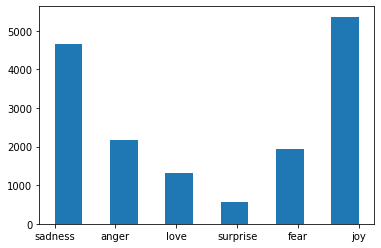

In [12]:
plt.hist(labels, bins=11)
plt.show()

In [13]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [14]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [15]:
train_labels = names_to_ids(labels)

In [16]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [18]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [19]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 20s 39ms/step - loss: 1.3752 - acc: 0.4576 - val_loss: 1.0075 - val_acc: 0.5985
Epoch 2/20
500/500 [==============================] - 18s 37ms/step - loss: 0.6425 - acc: 0.7806 - val_loss: 0.5349 - val_acc: 0.8200
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3397 - acc: 0.8883 - val_loss: 0.5065 - val_acc: 0.8205
Epoch 4/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2412 - acc: 0.9166 - val_loss: 0.4167 - val_acc: 0.8545
Epoch 5/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1641 - acc: 0.9464 - val_loss: 0.4228 - val_acc: 0.8750
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.1268 - acc: 0.9581 - val_loss: 0.5053 - val_acc: 0.8600
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.1230 - acc: 0.9611 - val_loss: 0.5286 - val_acc: 0.8565
Epoch 8/20
500/500 [==============================] - 18s 37ms

In [20]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

test_labels = names_to_ids(test_labels)
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 10ms/step - loss: 0.6244 - acc: 0.8565


In [31]:
i = random.randint(0, len(test_labels) - 1)

print("sentence: ", test_tweets[i])
print("Emotion: ", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print("Predicted Emotion: ", pred_class)

sentence:  when i heard the last regulation of the socialist govrenment concerning pensions
Emotion:  sadness
Predicted Emotion:  joy
